In [2]:
#回帰について学ぶ
#housing priceデータセットを使って学習を進める

import pandas as pd
import os 
import numpy as np

#house price df load
cdir = os.getcwd()

df_path = os.path.join(cdir,'python-machine-learning-book-3rd-edition/ch10/housing.data.txt')

#txtファイルも、区切り文字を指定することでdfとして読める
df = pd.read_csv(df_path,header=None,sep='\s+')
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

df.head()
#print(df.shape) 506*14

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


目的変数はMEDVということで進める

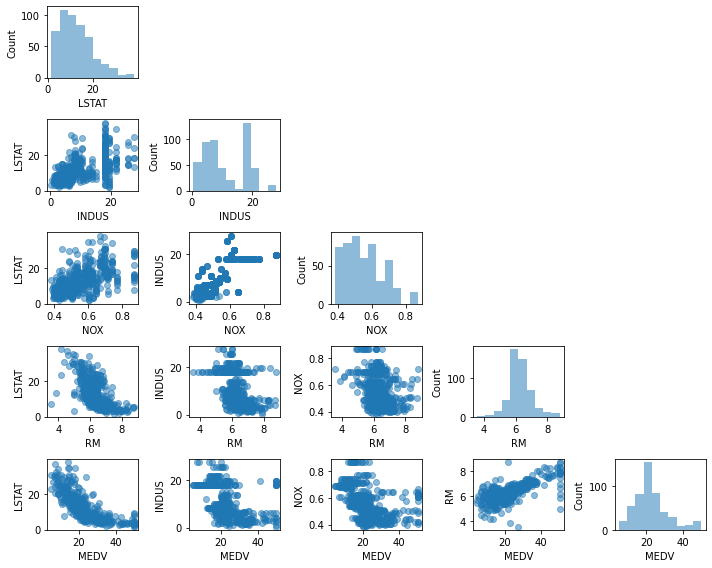

In [3]:
#散布図行列をつくってみる
#tidyverseのggplot的な相関係数と分布を一度に確認できるようなやつ
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix#mlxtendのscatteplormatrixってやつ

#decide cols
cols = ['LSTAT','INDUS','NOX','RM','MEDV']

#変数のペア関係をプロット
scatterplotmatrix(df[cols].values,figsize=(10,8),names=cols,alpha=.5)
plt.tight_layout()
plt.show()

<AxesSubplot:>

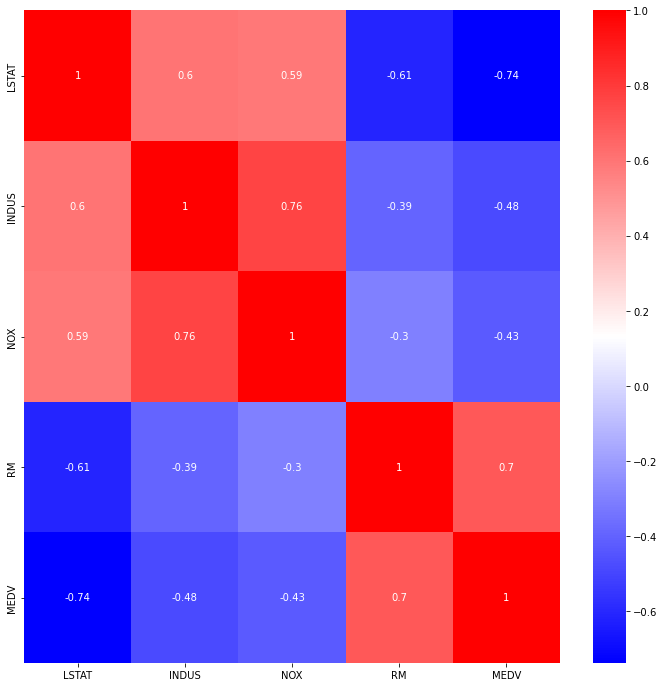

In [4]:
#つぎに、相関係数行列を作成
plt.figure(figsize=(12,12))
#5つの特徴量に限定
sns.heatmap(data=df[cols].corr(),cmap='bwr',annot=True)

線形モデルを適合させるときに重要なのは、目的変数と相関係数の高い特徴量<br>
この場合、LSTATが-0.74ともっとも高い相関があることがわかり、次にRMが0.7と高い<br>
<br>
ただし、MEDVとLSTATは散布図行列を見ると非線形の関係性であることがわかるが、MEDVとRMは線形っぽい関係性<br>
また、特徴量同士のRMとLSTAT同士の相関係数も-0.61と比較的高い

In [21]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        print(self.w_)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)
    
lk = LinearRegressionGD()
#エラーでてFITデキナイ　マジクソ
lk.fit(X,y)

[-6.56904465e+099 -2.94374650e+100 -6.55059275e+100 -7.93881737e+100
 -4.49580615e+098 -3.73808044e+099 -4.10179489e+100 -4.68629121e+101
 -2.35290146e+100 -7.26296470e+100 -2.89756418e+102 -1.22553964e+101
 -2.34120680e+102 -8.75848174e+100]


In [6]:
#動作確認
from sklearn.linear_model import LinearRegression

X = df[['RM']].values
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

lr = LinearRegression()
lr.fit(X_std, y_std)

LinearRegression()

In [7]:
LinearRegression.__init__

print(lr.score(X_std,y_std))
#重みの確認
print(lr.coef_)
#切片の確認
print(lr.intercept_)

0.483525455991334
[[0.69535995]]
[-4.43892061e-16]


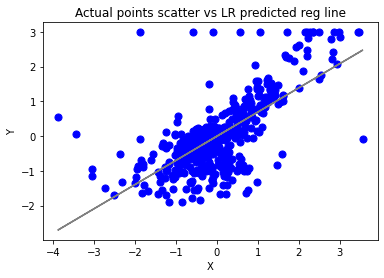

In [8]:
#plot
def lin_regplot(X,y,model):
    #X,yの散布図
    plt.scatter(X,y,c='blue',s=50)
    #predict結果を線として描画
    plt.plot(X,model.predict(X),c='gray')
    plt.title('Actual points scatter vs LR predicted reg line')
    plt.xlabel('X')
    plt.ylabel('Y')
lin_regplot(X_std,y_std,lr)

0.48352545599133423


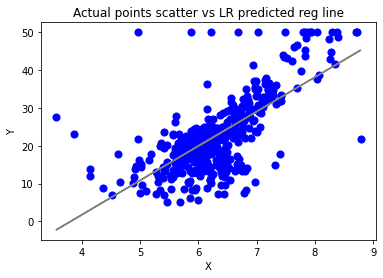

In [9]:
#データ標準化をしないで線形回帰した場合
lr2 = LinearRegression()
lr2.fit(X,y)

print(lr2.score(X,y))
lin_regplot(X,y,lr2)#同じようにうまく学習できている

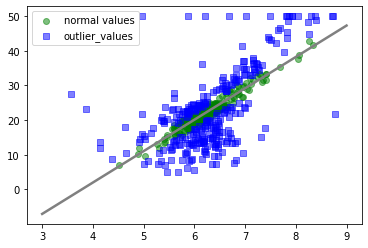

In [11]:
#外れ値に対応する手法 RANSACRegressor
from sklearn.linear_model import RANSACRegressor

"""
RANSACRegressorとは、データから外れ値を除外し、外れ値じゃないデータポイントでだけ学習をおこなうアルゴリズム
外れ値がどこからか？といった閾値の指定や、学習に使うアルゴリズムはユーザーが指定できる

"""
#instance
RR = RANSACRegressor(LinearRegression(),
                     max_trials=100,#iteration num
                     min_samples=50,#randomに選択される訓練データの数を50に設定
                     #1.正常値として学習させるランダムなデータポイント
                     loss='squared_error',#一つのデータポイントの推定vs実際の誤差計測は、誤差の二乗で行う
                     residual_threshold=5.0,#学習直線の予測と実測値の誤差が、5単位以内を正常値として学習に使う
                                            #5単位というのは、yの標準偏差の話で、残差が5単位以内のデータのみ正常値として使う
                     #手順2.正常値以外のすべてのデータポイントに対して、ここで指定した閾値に入るデータポイントを
                     #学習データとして追加で学習
                     
                     random_state=0)

RR.fit(X,y)

#正常値と異常値のマスク配列
normal_mask = RR.inlier_mask_#正常値を表す真偽値
outlier_mask = np.logical_not(RR.inlier_mask_)#外れ値を表す真偽値

#テキトーに3から9のXの配列を作成
line_X = np.arange(3,10,1)
#それをRANSACRegressorにぶちこんだときの予測値
line_y_ransac = RR.predict(line_X.reshape(-1,1))

#正常値をプロット
plt.scatter(X[normal_mask],y[normal_mask],c='g',label='normal values',marker='o',alpha=.5)
#外れ値をプロット
plt.scatter(X[outlier_mask],y[outlier_mask],c='b',label='outlier_values',marker='s',alpha=.5)
#RANSACRegressorによる予測値をプロット
plt.plot(line_X,line_y_ransac,color='gray',lw=2.5)
plt.legend()

In [12]:
#外れ値を除外したことで、線形モデルの切片と係数が、通常のLRとRansacだと少し異なる結果になった
print('LRの係数:{} LRの切片:{}'.format(lr2.coef_[0],lr2.intercept_))
print('RANSAC Regressorの係数:{} RANSAC Regressorの切片:{}'.format(RR.estimator_.coef_[0],RR.estimator_.intercept_))

LRの係数:[9.10210898] LRの切片:[-34.67062078]
RANSAC Regressorの係数:[9.0679517] RANSAC Regressorの切片:[-34.30155652]


In [13]:
#ただし外れ値を除外したからと言って、これが汎化性能が高いいいモデルなのかはわからない
#テストデータセットで、モデルの汎か性能をはかる
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

lra = LinearRegression()
lra.fit(X_train,y_train)

y_train_pred = lra.predict(X_train)
y_test_pred = lra.predict(X_test)


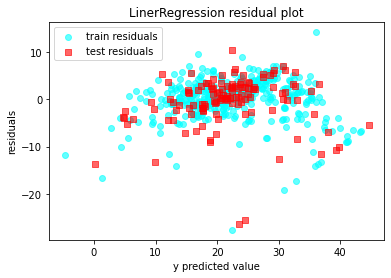

In [14]:
#線形モデルを診断するときに、残差プロットをして、残差が正規分布っぽく分布しているかどうかを確認する方法がある
plt.scatter(y_train_pred, y_train_pred - y_train, c='cyan',marker='o',label='train residuals',alpha=.6)
plt.scatter(y_test_pred, y_test_pred - y_test, c='red',marker='s',label='test residuals',alpha=.6)
plt.xlabel('y predicted value')
plt.ylabel('residuals')
plt.title('LinerRegression residual plot')
plt.legend()


In [15]:
#MSE on train/test
#MSEはモデルの汎か性能を測る指標であるが、特徴量のスケール次第で絶対値は変わるので、値の大きさで判断することはできない
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))

#いずれの指標でもtestの値がtrainよりも小さく、過学習気味であることがわかる

MSE
train 19.640519427908043
test 29.78224509230242
R2
train 0.7697699488741149
test 0.6354638433202122


In [16]:
#というわけで、汎か性能を確保するために、モデルの重みにペナルティをかけるため、RidgeとLasso,elasticnetという3つの正則化線形回帰を導入
from sklearn.linear_model import Lasso,Ridge,ElasticNet

ridge = Ridge(alpha=1.5)
lasso = Lasso(alpha=1.5)
enet = ElasticNet(alpha=1.0,l1_ratio=0.5)

#ridge
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print('RIDGE')
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))

#lasso
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print('LASSO')
print('MSE')
print('train',mean_squared_error(y_train,y_train_pred))
print('test',mean_squared_error(y_test,y_test_pred))

#値のスケールに依存しない性能評価として、r2_scoreがある
print('R2')
print('train',r2_score(y_train,y_train_pred))
print('test',r2_score(y_test,y_test_pred))


RIDGE
MSE
train 19.87659671763834
test 30.712417045197853
R2
train 0.7670026042178918
test 0.6240784924942776
LASSO
MSE
train 26.912427914829177
test 39.57625016993785
R2
train 0.6845272001335876
test 0.5155847355350733


Text(0, 0.5, 'MEDV')

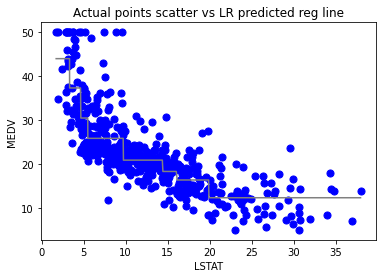

In [17]:
#ランダムフォレスト回帰を理解するために、決定木回帰の考え方を理解する
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

#決定木回帰インスタンス作成
tree = DecisionTreeRegressor(max_depth=3)
#fit
tree.fit(X,y)

#argsortによって、Xの小さい順のindexを取り出す
sort_idx = X.flatten().argsort()

#lin_regplot関数で、決定木回帰がどのような回帰直線を描くのかを見る
lin_regplot(X[sort_idx],y[sort_idx],tree)

plt.xlabel('LSTAT')
plt.ylabel('MEDV')

C:\Users\unlea\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


train MSE: 1.363
test MSE: 10.965
train R2 MSE: 0.984
test R2 MSE: 0.866


Text(0, 0.5, 'MEDV')

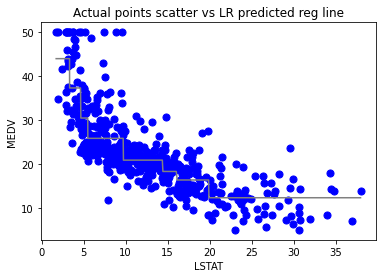

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=3,test_size=0.4)

#RFRのインスタンス化
RFR = RandomForestRegressor(n_estimators=1000,
                            #max_depth=3,
                            criterion='mse',#criterionは決定木の成長条件となる指標。このばあい、
                            #分割した時のMSEを最小化させるように、枝を成長させていく
                            random_state=1,
                            n_jobs=-1)
#Fit
RFR.fit(X_train,y_train)
#predict
y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

#MSEを出力
print('train MSE: {:.3f}'.format(mean_squared_error(y_train,y_train_pred)))
print('test MSE: {:.3f}'.format(mean_squared_error(y_test,y_test_pred)))

#決定係数を出力
print('train R2 MSE: {:.3f}'.format(r2_score(y_train,y_train_pred)))
print('test R2 MSE: {:.3f}'.format(r2_score(y_test,y_test_pred)))

#やはりtrainに過適合しており、過学習の傾向がみられる

#回帰直線を可視化(実際は多変量回帰だが、可視化の都合上LSTATだけ取り出して、yとの関係をみる)
sort_idx = X[:,-1].argsort()
lin_regplot(X[sort_idx][:,-1].reshape(-1,1),y[sort_idx],tree)

plt.xlabel('LSTAT')
plt.ylabel('MEDV')

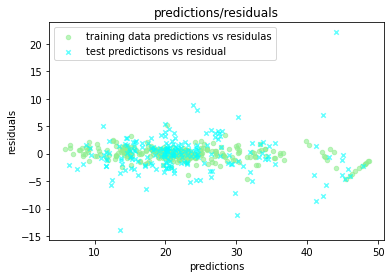

In [19]:
#予測値の残差を調べてみる
#予測値と残差をプロット
plt.scatter(y_train_pred,
            y_train_pred - y_train,#予測値と実際の値の差
            c='lightgreen',
            s=20,
            marker='o',
            alpha=.6,
            label='training data predictions vs residulas'
           )

plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='cyan',
            s=20,marker='x',
            alpha=.6,
            label='test predictisons vs residual')

plt.xlabel('predictions')
plt.ylabel('residuals')
plt.title('predictions/residuals')
plt.legend()